In [21]:
# %pip install numpy
# %pip install matplotlib
# %pip install matplotlib
# %pip install torch
# %pip install scikit-learn
# %pip install torchvision
# %pip install tqdm
%pip install timm

  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
Using cached timm-1.0.15-py3-none-any.whl (2.4 MB)
Using cached huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl (161 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.1-cp311-cp311-win_amd64.whl (102 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.4.0-py3-

In [7]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import torchvision.models as models

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
# 2. Path dataset
train_path = "H:/DACS4/BoneFractureDataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/"
val_path = "H:/DACS4/BoneFractureDataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/"
test_path = "H:/DACS4/BoneFractureDataset/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/"

In [9]:
# 3. Hàm lấy đường dẫn ảnh
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

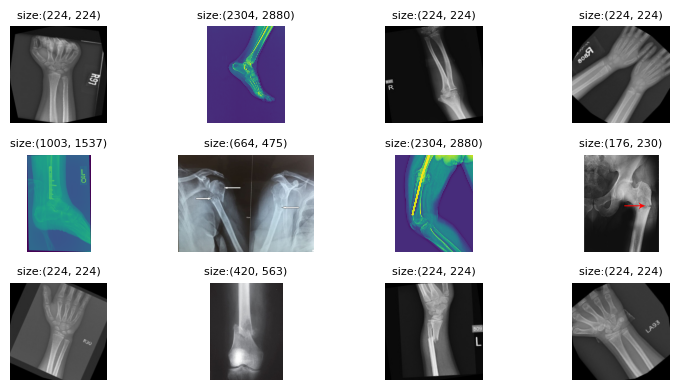

In [10]:
# 4. Hàm hiển thị dữ liệu
def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [11]:
# 5. Xử lý hình ảnh RGBA, LA, P
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode == 'RGBA' or img.mode == 'LA':
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA')
            img = img.convert('L')
        else:
            img = img.convert('L')
        return img

In [12]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [13]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

In [14]:
print(f"Số lượng lớp trong tập huấn luyện: {len(train_ds.classes)}")
print(f"Các lớp trong tập huấn luyện: {train_ds.classes}")
print(f"Số lượng lớp trong tập kiểm tra: {len(val_ds.classes)}")
print(f"Các lớp trong tập kiểm tra: {val_ds.classes}")

Số lượng lớp trong tập huấn luyện: 2
Các lớp trong tập huấn luyện: ['fractured', 'not fractured']
Số lượng lớp trong tập kiểm tra: 2
Các lớp trong tập kiểm tra: ['fractured', 'not fractured']


In [15]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].


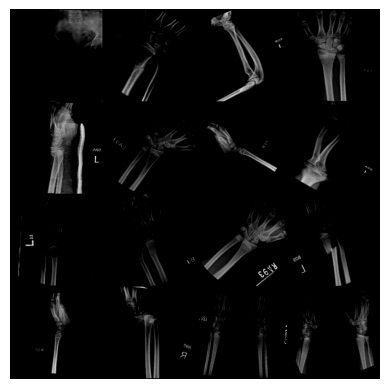

In [16]:
# 8. Xem thử batch ảnh
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [17]:
# 9. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
# # 10. Định nghĩa ResNet Model
# class ResNetModel(nn.Module):
#     def __init__(self, num_classes):
#         super(ResNetModel, self).__init__()
#         self.model = models.resnet18(pretrained=True)
#         self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

#     def forward(self, x):
#         return self.model(x)

# num_classes = len(train_ds.classes)
# model = ResNetModel(num_classes=num_classes).to(device)


import timm

model = timm.create_model('resnet18.a1_in1k', pretrained=True, num_classes=2)

# 2. Freeze toàn bộ các tham số trước
for param in model.parameters():
    param.requires_grad = False

# 3. Chỉ fine-tune layer cuối (layer4) + classifier
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# 4. Sửa lại Conv2d đầu vào nếu ảnh là grayscale (1 kênh)
out_channels = model.conv1.out_channels
kernel_size = model.conv1.kernel_size
stride = model.conv1.stride
padding = model.conv1.padding
bias = model.conv1.bias is not None

model.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=out_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding,
    bias=bias
)

# 5. Move model to device
model = model.to(device)
# 6. Loss function, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

h:\Fracture_Bone_Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
h:\Fracture_Bone_Prediction\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Viet\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer

In [23]:
def train_one_epoch(model, train_dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [24]:
def validate(model, val_dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / len(val_dataloader.dataset)
    avg_loss = total_loss / len(val_dataloader)

    return avg_loss, accuracy, all_labels, all_predictions


In [25]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    accuracies = []
    all_labels = []
    all_predictions = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer)
        val_loss, accuracy, epoch_labels, epoch_predictions = validate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)

        all_labels.extend(epoch_labels)
        all_predictions.extend(epoch_predictions)

        scheduler.step()

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.2f}%')

    return train_losses, val_losses, accuracies, all_labels, all_predictions

In [26]:
train_losses, val_losses, accuracies, all_labels, all_predictions = train(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler
)

  3%|▎         | 5/145 [00:23<10:44,  4.61s/it]


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('FracturedDataResnet/model.pt'))
model.to(device)

In [ ]:
def plot_curves(train_losses, val_losses, accuracies):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='green')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, accuracies)

In [ ]:
def predict_image(image_path, model, transforms, device):
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0)  # Thêm batch dimension

    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

In [ ]:
image_path = random.choice(get_image_paths(test_path))
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

predicted_class = predict_image(image_path, model, val_transforms, device)
true_class = image_path.split('/')[-2]

print(f"predict: {predicted_class} ({train_ds.classes[predicted_class]})")
print(f"true label: {true_class}")

In [ ]:
test_transforms = v2.Compose([
    HandleTransparency(),
    v2.Grayscale(1),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

test_ds = ImageFolder(test_path, transform=test_transforms)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [ ]:
def measure_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

print(f"Validation Accuracy: {measure_accuracy(model, val_dataloader):.2f}%")
print(f"Test Accuracy: {measure_accuracy(model, test_dataloader):.2f}%")
